### Project 3: Language Translation
#### Goal: Here our goal is to fine tune a pretrained language model that are designed for multiple languages to a specific language. 
#### Approach: We choose pretrained mBART50 and mBART25 from Facebook. mBART25 has 25 languages and mBART50 has 50. First we estimate accuracy of these pretrained model on all available language (for these model) using OPUS 100 dataset. Based on the performance, we chose a language where mBART50 performs poorly and is out of scope of mBART25 model. Then using OPUS-100 dataset, we finetune mBART50 for that specific language. Also, we finetune mBART25 so that it can translate to that target laguage as well even if it was originally out of mBART25's scope. 

In [1]:
from transformers import MBartTokenizer
from transformers import MBart50Tokenizer
import numpy as np
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from datasets import load_dataset
from sacrebleu.metrics import BLEU
import pandas as pd
import torch
from tqdm import tqdm

/projects/gt47/amondal2/Source/miniconda3/envs/torch_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!pip install sentencepiece
#!pip install sacrebleu
!pip install datasets

  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
  Using cached pyarrow-19.0.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
Using cached datasets-3.5.0-py3-none-any.whl (491 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
Using cached pyarrow-19.0.1-cp310-cp310-manylinux_2_28_x86_64.whl (42.1 MB)
Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.3.3 requires dill>=0.3.9, but you have dill 0.3.8 which is incompatible.
pathos 0.3.3 require

In [2]:
# Mapping of language codes to full language names for mBART-50
lang_names_50 = {
    # Original mBART-25 languages
    "ar_AR": "Arabic",
    "cs_CZ": "Czech",
    "de_DE": "German",
    "en_XX": "English",
    "es_XX": "Spanish",
    "et_EE": "Estonian",
    "fi_FI": "Finnish",
    "fr_XX": "French",
    "gu_IN": "Gujarati",
    "hi_IN": "Hindi",
    "it_IT": "Italian",
    "ja_XX": "Japanese",
    "kk_KZ": "Kazakh",
    "ko_KR": "Korean",
    "lt_LT": "Lithuanian",
    "lv_LV": "Latvian",
    "my_MM": "Burmese",
    "ne_NP": "Nepali",
    "nl_XX": "Dutch",
    "ro_RO": "Romanian",
    "ru_RU": "Russian",
    "si_LK": "Sinhala",
    "tr_TR": "Turkish",
    "vi_VN": "Vietnamese",
    "zh_CN": "Chinese",
    
    # Additional languages in mBART-50
    "af_ZA": "Afrikaans",
    "az_AZ": "Azerbaijani",
    "bn_IN": "Bengali",
    "fa_IR": "Persian",
    "he_IL": "Hebrew",
    "hr_HR": "Croatian",
    "id_ID": "Indonesian",
    "ka_GE": "Georgian",
    "km_KH": "Khmer",
    "mk_MK": "Macedonian",
    "ml_IN": "Malayalam",
    "mn_MN": "Mongolian",
    "mr_IN": "Marathi",
    "pl_PL": "Polish",
    "ps_AF": "Pashto",
    "pt_XX": "Portuguese",
    "sv_SE": "Swedish",
    "sw_KE": "Swahili",
    "ta_IN": "Tamil",
    "te_IN": "Telugu",
    "th_TH": "Thai",
    "tl_XX": "Tagalog",
    "uk_UA": "Ukrainian",
    "ur_PK": "Urdu",
    "xh_ZA": "Xhosa",
    "gl_ES": "Galician",
    "sl_SI": "Slovene"
}


In [3]:
model_name = 'facebook/mbart-large-50-many-to-many-mmt'
tokenizer = MBart50Tokenizer.from_pretrained(model_name)

# Getting the list of supported languages
supported_langs_50 = tokenizer.lang_code_to_id
print("Supported Languages in mBART-50:")
print("\nLanguage Codes with Full Names for mBART-50:")
for lang_code in sorted(lang_names_50.keys()):
    lang_id = lang_code in supported_langs_50 and supported_langs_50[lang_code] or "Unknown"
    print(f"{lang_code} ({lang_id}): {lang_names_50[lang_code]}")

Supported Languages in mBART-50:

Language Codes with Full Names for mBART-50:
af_ZA (250026): Afrikaans
ar_AR (250001): Arabic
az_AZ (250027): Azerbaijani
bn_IN (250028): Bengali
cs_CZ (250002): Czech
de_DE (250003): German
en_XX (250004): English
es_XX (250005): Spanish
et_EE (250006): Estonian
fa_IR (250029): Persian
fi_FI (250007): Finnish
fr_XX (250008): French
gl_ES (250051): Galician
gu_IN (250009): Gujarati
he_IL (250030): Hebrew
hi_IN (250010): Hindi
hr_HR (250031): Croatian
id_ID (250032): Indonesian
it_IT (250011): Italian
ja_XX (250012): Japanese
ka_GE (250033): Georgian
kk_KZ (250013): Kazakh
km_KH (250034): Khmer
ko_KR (250014): Korean
lt_LT (250015): Lithuanian
lv_LV (250016): Latvian
mk_MK (250035): Macedonian
ml_IN (250036): Malayalam
mn_MN (250037): Mongolian
mr_IN (250038): Marathi
my_MM (250017): Burmese
ne_NP (250018): Nepali
nl_XX (250019): Dutch
pl_PL (250039): Polish
ps_AF (250040): Pashto
pt_XX (250041): Portuguese
ro_RO (250020): Romanian
ru_RU (250021): Russi

In [4]:
from datasets import get_dataset_config_names

# Get all available language pairs in opus100 (e.g., "en-de", "en-pl", etc.)
available_pairs = get_dataset_config_names("opus100")

# Create the mapping automatically for all supported languages in mBART-50
language_datasets = {}
for lang_code in lang_names_50:
    # Remove region for comparison (e.g., pl_PL -> pl)
    if lang_code.startswith("en_XX"):
        continue
    lang_pair_code = lang_code.split("_")[0]  # e.g., "pl_PL" -> "pl"

    # Check if 'en-<lang>' is available
    candidate_pair = f"en-{lang_pair_code}"
    if candidate_pair in available_pairs:
        language_datasets[lang_code] = ("opus100", candidate_pair)

# Print to confirm
print(language_datasets)

{'es_XX': ('opus100', 'en-es'), 'et_EE': ('opus100', 'en-et'), 'fi_FI': ('opus100', 'en-fi'), 'fr_XX': ('opus100', 'en-fr'), 'gu_IN': ('opus100', 'en-gu'), 'hi_IN': ('opus100', 'en-hi'), 'it_IT': ('opus100', 'en-it'), 'ja_XX': ('opus100', 'en-ja'), 'kk_KZ': ('opus100', 'en-kk'), 'ko_KR': ('opus100', 'en-ko'), 'lt_LT': ('opus100', 'en-lt'), 'lv_LV': ('opus100', 'en-lv'), 'my_MM': ('opus100', 'en-my'), 'ne_NP': ('opus100', 'en-ne'), 'nl_XX': ('opus100', 'en-nl'), 'ro_RO': ('opus100', 'en-ro'), 'ru_RU': ('opus100', 'en-ru'), 'si_LK': ('opus100', 'en-si'), 'tr_TR': ('opus100', 'en-tr'), 'vi_VN': ('opus100', 'en-vi'), 'zh_CN': ('opus100', 'en-zh'), 'fa_IR': ('opus100', 'en-fa'), 'he_IL': ('opus100', 'en-he'), 'hr_HR': ('opus100', 'en-hr'), 'id_ID': ('opus100', 'en-id'), 'ka_GE': ('opus100', 'en-ka'), 'km_KH': ('opus100', 'en-km'), 'mk_MK': ('opus100', 'en-mk'), 'ml_IN': ('opus100', 'en-ml'), 'mn_MN': ('opus100', 'en-mn'), 'mr_IN': ('opus100', 'en-mr'), 'pl_PL': ('opus100', 'en-pl'), 'ps_AF'

In [6]:
model_name_25 = 'facebook/mbart-large-cc25'
tokenizer_25 = MBartTokenizer.from_pretrained(model_name_25)

# Getting the list of supported languages for mBART-25
supported_langs_25 = tokenizer_25.lang_code_to_id
print("\nSupported Languages in mBART-25:")
print("\nLanguage Codes with Full Names for mBART-25:")
for lang_code in sorted(lang_names_50.keys()):
    lang_id = lang_code in supported_langs_25 and supported_langs_25[lang_code] or "Unknown"
    print(f"{lang_code} ({lang_id}): {lang_names_50[lang_code]}")


Supported Languages in mBART-25:

Language Codes with Full Names for mBART-25:
af_ZA (Unknown): Afrikaans
ar_AR (250001): Arabic
az_AZ (Unknown): Azerbaijani
bn_IN (Unknown): Bengali
cs_CZ (250002): Czech
de_DE (250003): German
en_XX (250004): English
es_XX (250005): Spanish
et_EE (250006): Estonian
fa_IR (Unknown): Persian
fi_FI (250007): Finnish
fr_XX (250008): French
gl_ES (Unknown): Galician
gu_IN (250009): Gujarati
he_IL (Unknown): Hebrew
hi_IN (250010): Hindi
hr_HR (Unknown): Croatian
id_ID (Unknown): Indonesian
it_IT (250011): Italian
ja_XX (250012): Japanese
ka_GE (Unknown): Georgian
kk_KZ (250013): Kazakh
km_KH (Unknown): Khmer
ko_KR (250014): Korean
lt_LT (250015): Lithuanian
lv_LV (250016): Latvian
mk_MK (Unknown): Macedonian
ml_IN (Unknown): Malayalam
mn_MN (Unknown): Mongolian
mr_IN (Unknown): Marathi
my_MM (250017): Burmese
ne_NP (250018): Nepali
nl_XX (250019): Dutch
pl_PL (Unknown): Polish
ps_AF (Unknown): Pashto
pt_XX (Unknown): Portuguese
ro_RO (250020): Romanian
ru_

#### Okay, we already got all the languages that are part of mBART25, mBART50 and OPUS100 set. Now, access these model on a subset of OPUS100 testset. 

In [15]:
### test performance

# Function to calculate BLEU score
def calculate_bleu(references, predictions):
    bleu = BLEU()
    return bleu.corpus_score(predictions, [references]).score

# Function to translate text using mBART model
def translate(model, tokenizer, src_texts, src_lang, tgt_lang, device="cuda" if torch.cuda.is_available() else "cpu"):
    # Prepare the text data
    model = model.to(device)
    tokenizer.src_lang = src_lang
    
    # Tokenize the source text
    inputs = tokenizer(src_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
    # Generate translation
    translated_tokens = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
        max_length=512
    )
    
    # Decode the generated tokens
    translations = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
    
    return translations

# Function to evaluate model on a given language pair
def evaluate_language_pair(model, tokenizer, src_lang, tgt_lang, test_data_src, test_data_tgt):
    # Translate source texts
    translations = translate(model, tokenizer, test_data_src, src_lang, tgt_lang)
    
    # Calculate BLEU score
    bleu_score = calculate_bleu(test_data_tgt, translations)
    
    return bleu_score


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
from datasets import load_dataset


In [33]:
# Main evaluation function
def evaluate_models_on_languages():
    results = {
        'mBART-25': {},
        'mBART-50': {}
    }
    
    # Load models
    mbart25_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-cc25")
    mbart25_tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-cc25")
    
    mbart50_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
    mbart50_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
    
    # Get supported languages
    mbart25_langs = list(mbart25_tokenizer.lang_code_to_id.keys())
    mbart50_langs = list(mbart50_tokenizer.lang_code_to_id.keys())
    
    # Create a dictionary to map language codes to dataset configurations
    # language_datasets = {
    #     # Map only a few key languages with available datasets for demonstration
    #     "pl_PL": ("opus100", "en-pl"),
    #     "fa_IR": ("opus100", "en-fa"),
    #     "pt_XX": ("opus100", "en-pt"),
    #     # Add more languages as needed
    # }
    
    # Evaluate mBART-25 on its supported languages
    print("Evaluating mBART-25...")
    for tgt_lang in tqdm(mbart25_langs):
        if tgt_lang == "en_XX":  # Skip if target is English (source language in this example)
            continue
        
        try:
            # Load appropriate test data if available for this language
            if tgt_lang in language_datasets:
                dataset_name, config = language_datasets[tgt_lang]
                dataset = load_dataset(dataset_name, config, split="test[50:100]")
                
                # Get target language code for dataset (remove underscore and country code)
                dataset_tgt_lang = tgt_lang.split('_')[0].lower()
                
                # Check if the dataset has the expected structure and fields
                if "translation" in dataset.features and dataset_tgt_lang in dataset["translation"][0]:
                    # Extract source and target sentences
                    src_texts = [item["en"] for item in dataset["translation"]]
                    tgt_texts = [item[dataset_tgt_lang] for item in dataset["translation"]]
                    
                    bleu_score = evaluate_language_pair(
                        mbart25_model, 
                        mbart25_tokenizer,
                        "en_XX", 
                        tgt_lang,
                        src_texts,
                        tgt_texts
                    )
                    
                    results['mBART-25'][tgt_lang] = bleu_score
                else:
                    print(f"Dataset for {tgt_lang} doesn't have the expected structure")
                    results['mBART-25'][tgt_lang] = None
            else:
                print(f"No suitable dataset found for {tgt_lang}, skipping evaluation")
                results['mBART-25'][tgt_lang] = None
            
        except Exception as e:
            print(f"Error evaluating mBART-25 for {tgt_lang}: {e}")
            results['mBART-25'][tgt_lang] = None
    
    # Evaluate mBART-50 on its supported languages
    print("Evaluating mBART-50...")
    for tgt_lang in tqdm(mbart50_langs):
        if tgt_lang == "en_XX":  # Skip if target is English (source language in this example)
            continue
        
        try:
            # Load appropriate test data if available for this language
            if tgt_lang in language_datasets:
                dataset_name, config = language_datasets[tgt_lang]
                dataset = load_dataset(dataset_name, config, split="test[50:100]")
                
                # Get target language code for dataset (remove underscore and country code)
                dataset_tgt_lang = tgt_lang.split('_')[0].lower()
                
                # Check if the dataset has the expected structure and fields
                if "translation" in dataset.features and dataset_tgt_lang in dataset["translation"][0]:
                    # Extract source and target sentences
                    src_texts = [item["en"] for item in dataset["translation"]]
                    tgt_texts = [item[dataset_tgt_lang] for item in dataset["translation"]]
                    
                    bleu_score = evaluate_language_pair(
                        mbart50_model, 
                        mbart50_tokenizer,
                        "en_XX", 
                        tgt_lang,
                        src_texts,
                        tgt_texts
                    )
                    
                    results['mBART-50'][tgt_lang] = bleu_score
                else:
                    print(f"Dataset for {tgt_lang} doesn't have the expected structure")
                    results['mBART-50'][tgt_lang] = None
            else:
                print(f"No suitable dataset found for {tgt_lang}, skipping evaluation")
                results['mBART-50'][tgt_lang] = None
            
        except Exception as e:
            print(f"Error evaluating mBART-50 for {tgt_lang}: {e}")
            results['mBART-50'][tgt_lang] = None
    
    # Create a DataFrame to display results
    all_langs = sorted(set(mbart25_langs + mbart50_langs))
    df_data = []
    
    for lang in all_langs:
        row = {
            'Language Code': lang,
            'mBART-25 BLEU': results['mBART-25'].get(lang, 'Not supported'),
            'mBART-50 BLEU': results['mBART-50'].get(lang, 'Not supported')
        }
        df_data.append(row)
    
    results_df = pd.DataFrame(df_data)
    return results_df

# Run the evaluation
if __name__ == "__main__":
    results = evaluate_models_on_languages()
    print(results)
    
    # Save results to CSV
    results.to_csv('mbart_comparison_results.csv', index=False)
    print("Results saved to mbart_comparison_results.csv")

Evaluating mBART-25...


  0%|          | 0/25 [00:00<?, ?it/s]

No suitable dataset found for ar_AR, skipping evaluation
No suitable dataset found for cs_CZ, skipping evaluation
No suitable dataset found for de_DE, skipping evaluation


Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 538041.69 examples/s]

Generating train split: 100%|██████████| 318306/318306 [00:00<00:00, 2416507.62 examples/s]

Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 489103.14 examples/s]

Generating train split: 100%|██████████| 534319/534319 [00:00<00:00, 1460674.17 examples/s]

Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 531429.08 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2037982.24 examples/s]

Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 580848.08 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2524561.53 examples/s]

Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 598715.87 examples/s]

Generating train split: 100%|██████████| 79927/79927 [00:00<00:00, 2496077.14 examples/s]

Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 594557.23 examples/s]

Generating 

Error evaluating mBART-25 for ro_RO: An error occurred while generating the dataset


 84%|████████▍ | 21/25 [05:45<00:50, 12.68s/it]

Error evaluating mBART-25 for ru_RU: [Errno 122] Disk quota exceeded


 88%|████████▊ | 22/25 [05:50<00:31, 10.55s/it]

Error evaluating mBART-25 for si_LK: [Errno 122] Disk quota exceeded


 92%|█████████▏| 23/25 [05:53<00:16,  8.17s/it]

Error evaluating mBART-25 for tr_TR: [Errno 122] Disk quota exceeded


 96%|█████████▌| 24/25 [05:56<00:06,  6.76s/it]

Error evaluating mBART-25 for vi_VN: [Errno 122] Disk quota exceeded


100%|██████████| 25/25 [05:59<00:00, 14.38s/it]


Error evaluating mBART-25 for zh_CN: [Errno 122] Disk quota exceeded
Evaluating mBART-50...


  0%|          | 0/52 [00:00<?, ?it/s]

No suitable dataset found for ar_AR, skipping evaluation
No suitable dataset found for cs_CZ, skipping evaluation
No suitable dataset found for de_DE, skipping evaluation


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'en-ne' at /home/amondal2/.cache/huggingface/datasets/opus100/en-ne/0.0.0/805090dc28bf78897da9641cdf08b61287580df9 (last modified on Thu Apr 17 12:02:57 2025).
Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'en-nl' at /home/amondal2/.cache/huggingface/datasets/opus100/en-nl/0.0.0/805090dc28bf78897da9641cdf08b61287580df9 (last modified on Thu Apr 17 12:03:19 2025).
Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 38%|███▊      | 20/52 [00:56<01:05,  2.05s/it]

Error evaluating mBART-50 for ro_RO: Couldn't find cache for opus100 for config 'en-ro'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 40%|████      | 21/52 [00:57<00:48,  1.56s/it]

Error evaluating mBART-50 for ru_RU: Couldn't find cache for opus100 for config 'en-ru'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 42%|████▏     | 22/52 [00:57<00:36,  1.22s/it]

Error evaluating mBART-50 for si_LK: Couldn't find cache for opus100 for config 'en-si'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 44%|████▍     | 23/52 [00:58<00:30,  1.04s/it]

Error evaluating mBART-50 for tr_TR: Couldn't find cache for opus100 for config 'en-tr'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 46%|████▌     | 24/52 [00:58<00:23,  1.17it/s]

Error evaluating mBART-50 for vi_VN: Couldn't find cache for opus100 for config 'en-vi'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 48%|████▊     | 25/52 [00:59<00:19,  1.39it/s]

Error evaluating mBART-50 for zh_CN: Couldn't find cache for opus100 for config 'en-zh'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']
No suitable dataset found for af_ZA, skipping evaluation
No suitable dataset found for az_AZ, skipping evaluation
No suitable dataset found for bn_IN, skipping evaluation


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'en-fa' at /home/amondal2/.cache/huggingface/datasets/opus100/en-fa/0.0.0/805090dc28bf78897da9641cdf08b61287580df9 (last modified on Thu Apr 17 01:07:01 2025).
Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 58%|█████▊    | 30/52 [01:01<00:13,  1.68it/s]

Error evaluating mBART-50 for he_IL: Couldn't find cache for opus100 for config 'en-he'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 60%|█████▉    | 31/52 [01:02<00:11,  1.80it/s]

Error evaluating mBART-50 for hr_HR: Couldn't find cache for opus100 for config 'en-hr'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 62%|██████▏   | 32/52 [01:02<00:11,  1.75it/s]

Error evaluating mBART-50 for id_ID: Couldn't find cache for opus100 for config 'en-id'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 63%|██████▎   | 33/52 [01:03<00:10,  1.87it/s]

Error evaluating mBART-50 for ka_GE: Couldn't find cache for opus100 for config 'en-ka'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 65%|██████▌   | 34/52 [01:03<00:09,  1.98it/s]

Error evaluating mBART-50 for km_KH: Couldn't find cache for opus100 for config 'en-km'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 67%|██████▋   | 35/52 [01:04<00:08,  2.09it/s]

Error evaluating mBART-50 for mk_MK: Couldn't find cache for opus100 for config 'en-mk'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 69%|██████▉   | 36/52 [01:04<00:07,  2.18it/s]

Error evaluating mBART-50 for ml_IN: Couldn't find cache for opus100 for config 'en-ml'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 71%|███████   | 37/52 [01:05<00:06,  2.25it/s]

Error evaluating mBART-50 for mn_MN: Couldn't find cache for opus100 for config 'en-mn'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 73%|███████▎  | 38/52 [01:05<00:06,  2.00it/s]

Error evaluating mBART-50 for mr_IN: Couldn't find cache for opus100 for config 'en-mr'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'en-pl' at /home/amondal2/.cache/huggingface/datasets/opus100/en-pl/0.0.0/805090dc28bf78897da9641cdf08b61287580df9 (last modified on Thu Apr 17 01:02:11 2025).
Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
 77%|███████▋  | 40/52 [01:09<00:13,  1.12s/it]

Error evaluating mBART-50 for ps_AF: Couldn't find cache for opus100 for config 'en-ps'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'en-pt' at /home/amondal2/.cache/huggingface/datasets/opus100/en-pt/0.0.0/805090dc28bf78897da9641cdf08b61287580df9 (last modified on Thu Apr 17 01:08:08 2025).
 81%|████████  | 42/52 [01:14<00:18,  1.89s/it]

Error evaluating mBART-50 for sv_SE: [Errno 122] Disk quota exceeded
No suitable dataset found for sw_KE, skipping evaluation


 85%|████████▍ | 44/52 [01:17<00:13,  1.69s/it]

Error evaluating mBART-50 for ta_IN: [Errno 122] Disk quota exceeded


 87%|████████▋ | 45/52 [01:20<00:13,  1.87s/it]

Error evaluating mBART-50 for te_IN: [Errno 122] Disk quota exceeded


 88%|████████▊ | 46/52 [01:22<00:11,  1.91s/it]

Error evaluating mBART-50 for th_TH: [Errno 122] Disk quota exceeded
No suitable dataset found for tl_XX, skipping evaluation


 92%|█████████▏| 48/52 [01:24<00:06,  1.64s/it]

Error evaluating mBART-50 for uk_UA: [Errno 122] Disk quota exceeded


 94%|█████████▍| 49/52 [01:26<00:05,  1.75s/it]

Error evaluating mBART-50 for ur_PK: [Errno 122] Disk quota exceeded


 96%|█████████▌| 50/52 [01:29<00:03,  1.88s/it]

Error evaluating mBART-50 for xh_ZA: [Errno 122] Disk quota exceeded


 98%|█████████▊| 51/52 [01:30<00:01,  1.84s/it]

Error evaluating mBART-50 for gl_ES: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/opus100/paths-info/805090dc28bf78897da9641cdf08b61287580df9


Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
100%|██████████| 52/52 [01:31<00:00,  1.76s/it]

Error evaluating mBART-50 for sl_SI: Couldn't find cache for opus100 for config 'en-sl'
Available configs in the cache: ['en-es', 'en-et', 'en-fa', 'en-fi', 'en-fr', 'en-gu', 'en-hi', 'en-it', 'en-ja', 'en-kk', 'en-ko', 'en-lt', 'en-lv', 'en-my', 'en-ne', 'en-nl', 'en-pl', 'en-pt']
   Language Code  mBART-25 BLEU  mBART-50 BLEU
0          af_ZA  Not supported           None
1          ar_AR           None           None
2          az_AZ  Not supported           None
3          bn_IN  Not supported           None
4          cs_CZ           None           None
5          de_DE           None           None
6          en_XX  Not supported  Not supported
7          es_XX       0.452606      14.123204
8          et_EE       2.549456      27.919842
9          fa_IR  Not supported       5.146745
10         fi_FI       0.342536      13.864113
11         fr_XX       0.784129      32.090082
12         gl_ES  Not supported           None
13         gu_IN         0.1704       3.904954
14         h

#### Memory issue so had to run on smaller subset. Let's try a memory efficient approach to test on 100 datapoints

In [19]:
import os
import gc
import torch
from transformers import MBartForConditionalGeneration, MBartTokenizer, MBart50TokenizerFast
from datasets import load_dataset
from sacrebleu.metrics import BLEU
import pandas as pd
from tqdm import tqdm

# Set environment variables for better memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

# Function to clear GPU memory
def clear_gpu_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory after clearing: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

# Function to translate and evaluate
def evaluate_language_pair(model_name, tokenizer_name, src_lang, tgt_lang, dataset_name, dataset_config):
    # Load model and tokenizer
    print(f"Loading model {model_name} for {src_lang} to {tgt_lang}...")
    
    # Clear memory before loading new model
    clear_gpu_memory()
    
    model = MBartForConditionalGeneration.from_pretrained(model_name)
    
    if "mbart-large-cc25" in model_name:
        tokenizer = MBartTokenizer.from_pretrained(tokenizer_name)
    else:
        tokenizer = MBart50TokenizerFast.from_pretrained(tokenizer_name)
    
    # Load to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Load dataset
    print(f"Loading dataset {dataset_name} {dataset_config}...")
    dataset = load_dataset(dataset_name, dataset_config, split="test[:100]")
    
    # Get target language code for dataset
    dataset_tgt_lang = tgt_lang.split('_')[0].lower()
    
    # Check dataset structure
    if "translation" not in dataset.features or dataset_tgt_lang not in dataset["translation"][0]:
        print(f"Dataset doesn't have expected structure for {tgt_lang}")
        
        # Free memory before exiting
        del model, tokenizer
        clear_gpu_memory()
        return None
    
    # Extract texts
    src_texts = [item["en"] for item in dataset["translation"]]
    tgt_texts = [item[dataset_tgt_lang] for item in dataset["translation"]]
    
    # Process in small batches
    batch_size = 4
    translations = []
    tokenizer.src_lang = src_lang
    
    for i in range(0, len(src_texts), batch_size):
        batch_texts = src_texts[i:i+batch_size]
        
        # Tokenize
        inputs = tokenizer(
            batch_texts, 
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            max_length=128
        ).to(device)
        
        # Generate 
        with torch.no_grad():
            translated_tokens = model.generate(
                **inputs,
                forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
                max_length=128,
                num_beams=2,
                early_stopping=True
            )
        
        # Decode and append
        batch_translations = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
        translations.extend(batch_translations)
        
        # Clear batch memory
        del inputs, translated_tokens
        torch.cuda.empty_cache()
    
    # Calculate BLEU
    bleu = BLEU()
    bleu_score = bleu.corpus_score(translations, [tgt_texts]).score
    
    # Print result
    print(f"BLEU score for {src_lang} to {tgt_lang}: {bleu_score:.2f}")
    
    # Free memory
    del model, tokenizer, dataset, translations
    clear_gpu_memory()
    
    return bleu_score

# Main evaluation function 
def evaluate_models_on_languages():
    results = {
        'mBART-25': {},
        'mBART-50': {}
    }
    
    # Define model paths
    mbart25_model = "facebook/mbart-large-cc25"
    mbart25_tokenizer = "facebook/mbart-large-cc25"
    
    mbart50_model = "facebook/mbart-large-50-many-to-many-mmt"
    mbart50_tokenizer = "facebook/mbart-large-50-many-to-many-mmt"
    
    # Get language lists
    print("Getting language lists...")
    temp_tokenizer25 = MBartTokenizer.from_pretrained(mbart25_tokenizer)
    mbart25_langs = list(temp_tokenizer25.lang_code_to_id.keys())
    del temp_tokenizer25
    
    temp_tokenizer50 = MBart50TokenizerFast.from_pretrained(mbart50_tokenizer)
    mbart50_langs = list(temp_tokenizer50.lang_code_to_id.keys())
    del temp_tokenizer50
    
    clear_gpu_memory()
    
    # # Create a dictionary to map language codes to dataset configurations
    # language_datasets = {
    #     "pl_PL": ("opus100", "en-pl"),
    #     "fa_IR": ("opus100", "en-fa"),
    #     "pt_XX": ("opus100", "en-pt"),
    #     # Add more languages as needed
    # }
    
    # Test limited languages for memory issues
    test_langs_25 = [lang for lang in mbart25_langs if lang in language_datasets and lang != "en_XX"]
    test_langs_50 = [lang for lang in mbart50_langs if lang in language_datasets and lang != "en_XX"]
    
    # Evaluate mBART-25 one language at a time
    print("Evaluating mBART-25...")
    for tgt_lang in tqdm(test_langs_25):
        if tgt_lang in language_datasets:
            dataset_name, config = language_datasets[tgt_lang]
            try:
                results['mBART-25'][tgt_lang] = evaluate_language_pair(
                    mbart25_model,
                    mbart25_tokenizer,
                    "en_XX",
                    tgt_lang,
                    dataset_name,
                    config
                )
            except Exception as e:
                print(f"Error evaluating mBART-25 for {tgt_lang}: {e}")
                results['mBART-25'][tgt_lang] = None
    
    # Evaluate mBART-50 one language at a time
    print("Evaluating mBART-50...")
    for tgt_lang in tqdm(test_langs_50):
        if tgt_lang in language_datasets:
            dataset_name, config = language_datasets[tgt_lang]
            try:
                results['mBART-50'][tgt_lang] = evaluate_language_pair(
                    mbart50_model,
                    mbart50_tokenizer,
                    "en_XX",
                    tgt_lang,
                    dataset_name,
                    config
                )
            except Exception as e:
                print(f"Error evaluating mBART-50 for {tgt_lang}: {e}")
                results['mBART-50'][tgt_lang] = None
    
    # Create a DataFrame to display results
    all_langs = sorted(set(test_langs_25 + test_langs_50))
    df_data = []
    
    for lang in all_langs:
        row = {
            'Language Code': lang,
            'mBART-25 BLEU': results['mBART-25'].get(lang, 'Not supported'),
            'mBART-50 BLEU': results['mBART-50'].get(lang, 'Not supported')
        }
        df_data.append(row)
    
    results_df = pd.DataFrame(df_data)
    return results_df

# Run the evaluation
if __name__ == "__main__":
    results = evaluate_models_on_languages()
    print(results)
    
    # Save results to CSV
    results.to_csv('mbart_comparison_results2.csv', index=False)
    print("Results saved to mbart_comparison_results2.csv")

Getting language lists...
GPU memory after clearing: 25.10 GB
Evaluating mBART-25...


  0%|          | 0/21 [00:00<?, ?it/s]

Loading model facebook/mbart-large-cc25 for en_XX to es_XX...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-es...


  5%|▍         | 1/21 [00:18<06:12, 18.60s/it]

BLEU score for en_XX to es_XX: 1.92
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to et_EE...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-et...


 10%|▉         | 2/21 [00:52<08:40, 27.38s/it]

BLEU score for en_XX to et_EE: 2.74
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to fi_FI...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-fi...


 14%|█▍        | 3/21 [01:10<06:55, 23.06s/it]

BLEU score for en_XX to fi_FI: 1.29
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to fr_XX...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-fr...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 463946.02 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 1478439.23 examples/s]

 19%|█▉        | 4/21 [01:33<06:37, 23.39s/it]

BLEU score for en_XX to fr_XX: 0.57
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to gu_IN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-gu...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 604105.43 examples/s]

Generating train split: 100%|██████████| 318306/318306 [00:00<00:00, 2443853.22 examples/s]

 24%|██▍       | 5/21 [01:56<06:07, 22.95s/it]

BLEU score for en_XX to gu_IN: 1.99
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to hi_IN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-hi...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 469240.25 examples/s]

Generating train split: 100%|██████████| 534319/534319 [00:00<00:00, 1503833.11 examples/s]

 29%|██▊       | 6/21 [02:16<05:33, 22.25s/it]

BLEU score for en_XX to hi_IN: 0.30
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to it_IT...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-it...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 536184.60 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2060038.35 examples/s]

 33%|███▎      | 7/21 [02:36<04:57, 21.22s/it]

BLEU score for en_XX to it_IT: 1.95
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to ja_XX...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ja...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 571820.59 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2552038.90 examples/s]

 38%|███▊      | 8/21 [02:52<04:17, 19.80s/it]

BLEU score for en_XX to ja_XX: 1.12
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to kk_KZ...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-kk...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 609858.81 examples/s]

Generating train split: 100%|██████████| 79927/79927 [00:00<00:00, 2484386.43 examples/s]

 43%|████▎     | 9/21 [03:22<04:34, 22.85s/it]

BLEU score for en_XX to kk_KZ: 0.04
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to ko_KR...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ko...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 543937.75 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2410865.93 examples/s]

 48%|████▊     | 10/21 [03:48<04:22, 23.86s/it]

BLEU score for en_XX to ko_KR: 0.26
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to lt_LT...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-lt...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 471906.39 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 1678685.17 examples/s]

 52%|█████▏    | 11/21 [04:18<04:17, 25.75s/it]

BLEU score for en_XX to lt_LT: 3.00
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to lv_LV...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-lv...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 439447.22 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 1506181.94 examples/s]

 57%|█████▋    | 12/21 [04:40<03:39, 24.44s/it]

BLEU score for en_XX to lv_LV: 1.48
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to my_MM...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-my...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 543726.21 examples/s]

Generating train split: 100%|██████████| 24594/24594 [00:00<00:00, 1790041.34 examples/s]

 62%|██████▏   | 13/21 [05:02<03:10, 23.77s/it]

BLEU score for en_XX to my_MM: 0.77
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to ne_NP...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ne...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 538352.46 examples/s]

Generating train split: 100%|██████████| 406381/406381 [00:00<00:00, 2496814.62 examples/s]

 67%|██████▋   | 14/21 [05:18<02:30, 21.55s/it]

BLEU score for en_XX to ne_NP: 2.29
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to nl_XX...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-nl...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 523993.25 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2188586.78 examples/s]

 71%|███████▏  | 15/21 [05:37<02:04, 20.76s/it]

BLEU score for en_XX to nl_XX: 0.98
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to ro_RO...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ro...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 539495.02 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2606211.58 examples/s]

 76%|███████▌  | 16/21 [06:10<02:02, 24.53s/it]

BLEU score for en_XX to ro_RO: 1.72
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to ru_RU...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ru...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 459700.13 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 1605207.94 examples/s]

 81%|████████  | 17/21 [06:36<01:38, 24.73s/it]

BLEU score for en_XX to ru_RU: 4.35
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to si_LK...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-si...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 554142.42 examples/s]

Generating train split: 100%|██████████| 979109/979109 [00:00<00:00, 2343744.39 examples/s]

 86%|████████▌ | 18/21 [06:50<01:05, 21.72s/it]

BLEU score for en_XX to si_LK: 1.15
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to tr_TR...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-tr...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 568603.54 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2697112.55 examples/s]

 90%|█████████ | 19/21 [07:14<00:44, 22.37s/it]

BLEU score for en_XX to tr_TR: 1.26
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to vi_VN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-vi...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 571197.60 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2672593.44 examples/s]

 95%|█████████▌| 20/21 [07:37<00:22, 22.55s/it]

BLEU score for en_XX to vi_VN: 2.34
GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-cc25 for en_XX to zh_CN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-zh...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 437887.35 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 1556754.32 examples/s]

100%|██████████| 21/21 [07:57<00:00, 22.73s/it]


BLEU score for en_XX to zh_CN: 0.57
GPU memory after clearing: 25.10 GB
Evaluating mBART-50...


  0%|          | 0/43 [00:00<?, ?it/s]

Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to es_XX...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-es...
BLEU score for en_XX to es_XX: 18.53


  2%|▏         | 1/43 [00:11<07:42, 11.01s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to et_EE...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-et...
BLEU score for en_XX to et_EE: 19.95


  5%|▍         | 2/43 [00:21<07:20, 10.74s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to fi_FI...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-fi...
BLEU score for en_XX to fi_FI: 16.90


  7%|▋         | 3/43 [00:38<08:57, 13.43s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to fr_XX...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-fr...
BLEU score for en_XX to fr_XX: 35.85


  9%|▉         | 4/43 [00:49<08:09, 12.56s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to gu_IN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-gu...
BLEU score for en_XX to gu_IN: 5.98


 12%|█▏        | 5/43 [01:11<10:03, 15.88s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to hi_IN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-hi...
BLEU score for en_XX to hi_IN: 19.88


 14%|█▍        | 6/43 [01:28<10:08, 16.46s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to it_IT...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-it...
BLEU score for en_XX to it_IT: 17.71


 16%|█▋        | 7/43 [01:41<09:11, 15.33s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to ja_XX...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ja...
BLEU score for en_XX to ja_XX: 3.79


 19%|█▊        | 8/43 [01:53<08:13, 14.10s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to kk_KZ...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-kk...
BLEU score for en_XX to kk_KZ: 1.32


 21%|██        | 9/43 [02:04<07:28, 13.19s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to ko_KR...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ko...
BLEU score for en_XX to ko_KR: 2.30


 23%|██▎       | 10/43 [02:18<07:19, 13.31s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to lt_LT...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-lt...
BLEU score for en_XX to lt_LT: 26.98


 26%|██▌       | 11/43 [02:34<07:40, 14.41s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to lv_LV...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-lv...
BLEU score for en_XX to lv_LV: 28.93


 28%|██▊       | 12/43 [02:52<07:54, 15.32s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to my_MM...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-my...
BLEU score for en_XX to my_MM: 2.25


 30%|███       | 13/43 [03:09<07:53, 15.79s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to ne_NP...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ne...
BLEU score for en_XX to ne_NP: 51.14


 33%|███▎      | 14/43 [03:19<06:47, 14.05s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to nl_XX...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-nl...
BLEU score for en_XX to nl_XX: 21.24


 35%|███▍      | 15/43 [03:37<07:09, 15.32s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to ro_RO...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ro...
BLEU score for en_XX to ro_RO: 23.28


 37%|███▋      | 16/43 [03:50<06:36, 14.70s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to ru_RU...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ru...
BLEU score for en_XX to ru_RU: 21.53


 40%|███▉      | 17/43 [04:02<06:01, 13.91s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to si_LK...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-si...
BLEU score for en_XX to si_LK: 7.60


 42%|████▏     | 18/43 [04:19<06:05, 14.61s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to tr_TR...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-tr...
BLEU score for en_XX to tr_TR: 14.90


 44%|████▍     | 19/43 [04:31<05:34, 13.93s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to vi_VN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-vi...
BLEU score for en_XX to vi_VN: 16.54


 47%|████▋     | 20/43 [04:44<05:16, 13.76s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to zh_CN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-zh...
BLEU score for en_XX to zh_CN: 1.37


 49%|████▉     | 21/43 [05:01<05:21, 14.61s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to fa_IR...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-fa...
BLEU score for en_XX to fa_IR: 4.03


 51%|█████     | 22/43 [05:12<04:42, 13.44s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to he_IL...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-he...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 484330.72 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2576499.41 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 545210.45 examples/s]


BLEU score for en_XX to he_IL: 21.85


 53%|█████▎    | 23/43 [05:23<04:16, 12.83s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to hr_HR...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-hr...


 56%|█████▌    | 24/43 [05:38<04:16, 13.48s/it]

Error evaluating mBART-50 for hr_HR: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache. Please check your connection and try again or make sure your Internet connection is on.
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to id_ID...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-id...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 548956.74 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2710903.19 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 581936.04 examples/s]


BLEU score for en_XX to id_ID: 25.44


 58%|█████▊    | 25/43 [05:48<03:43, 12.40s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to ka_GE...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ka...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 519869.11 examples/s]

Generating train split: 100%|██████████| 377306/377306 [00:00<00:00, 2368488.03 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 561373.75 examples/s]


BLEU score for en_XX to ka_GE: 0.90


 60%|██████    | 26/43 [06:01<03:35, 12.66s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to km_KH...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-km...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 557864.47 examples/s]

Generating train split: 100%|██████████| 111483/111483 [00:00<00:00, 1865576.11 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 618218.59 examples/s]


BLEU score for en_XX to km_KH: 15.20


 63%|██████▎   | 27/43 [06:14<03:21, 12.59s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to mk_MK...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-mk...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 512343.98 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2216007.57 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 546560.33 examples/s]


BLEU score for en_XX to mk_MK: 15.24


 65%|██████▌   | 28/43 [06:28<03:17, 13.19s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to ml_IN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ml...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 528017.12 examples/s]

Generating train split: 100%|██████████| 822746/822746 [00:00<00:00, 1514877.42 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 511375.76 examples/s]


BLEU score for en_XX to ml_IN: 3.45


 67%|██████▋   | 29/43 [06:41<03:04, 13.19s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to mn_MN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-mn...



 70%|██████▉   | 30/43 [06:58<03:03, 14.15s/it]

Error evaluating mBART-50 for mn_MN: Unknown split "test". Should be one of ['train'].
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to mr_IN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-mr...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 549712.19 examples/s]

Generating train split: 100%|██████████| 27007/27007 [00:00<00:00, 2019460.32 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 774929.15 examples/s]


BLEU score for en_XX to mr_IN: 4.97


 72%|███████▏  | 31/43 [07:15<03:02, 15.18s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to pl_PL...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-pl...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 539182.93 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2413680.91 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 508308.07 examples/s]


BLEU score for en_XX to pl_PL: 13.95


 74%|███████▍  | 32/43 [07:27<02:33, 13.99s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to ps_AF...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ps...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 586124.09 examples/s]

Generating train split: 100%|██████████| 79127/79127 [00:00<00:00, 3042952.82 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 694708.74 examples/s]


BLEU score for en_XX to ps_AF: 11.34


 77%|███████▋  | 33/43 [07:34<02:00, 12.00s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to pt_XX...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-pt...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 532035.77 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2016591.20 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 530890.96 examples/s]


BLEU score for en_XX to pt_XX: 29.91


 79%|███████▉  | 34/43 [07:49<01:56, 13.00s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to sv_SE...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-sv...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 522069.21 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2176668.98 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 531025.38 examples/s]


BLEU score for en_XX to sv_SE: 21.98


 81%|████████▏ | 35/43 [08:00<01:39, 12.42s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to ta_IN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ta...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 522394.32 examples/s]

Generating train split: 100%|██████████| 227014/227014 [00:00<00:00, 1259335.22 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 548884.90 examples/s]


BLEU score for en_XX to ta_IN: 8.76


 84%|████████▎ | 36/43 [08:11<01:23, 12.00s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to te_IN...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-te...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 594220.30 examples/s]

Generating train split: 100%|██████████| 64352/64352 [00:00<00:00, 2252550.39 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 699983.98 examples/s]


BLEU score for en_XX to te_IN: 40.72


 86%|████████▌ | 37/43 [08:20<01:06, 11.05s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to th_TH...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-th...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 529550.41 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2009763.47 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 536458.91 examples/s]


BLEU score for en_XX to th_TH: 0.23


 88%|████████▊ | 38/43 [08:32<00:57, 11.44s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to uk_UA...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-uk...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 546311.17 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 2271704.06 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 527917.43 examples/s]


BLEU score for en_XX to uk_UA: 9.31


 91%|█████████ | 39/43 [08:44<00:45, 11.37s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to ur_PK...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-ur...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 451291.59 examples/s]

Generating train split: 100%|██████████| 753913/753913 [00:00<00:00, 837545.01 examples/s] 

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 37790.95 examples/s]


BLEU score for en_XX to ur_PK: 7.10


 93%|█████████▎| 40/43 [09:08<00:45, 15.13s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to xh_ZA...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-xh...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 477113.41 examples/s]

Generating train split: 100%|██████████| 439671/439671 [00:00<00:00, 1706414.70 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 31895.97 examples/s]


BLEU score for en_XX to xh_ZA: 2.39


 95%|█████████▌| 41/43 [09:28<00:33, 16.73s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to gl_ES...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-gl...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 538594.41 examples/s]

Generating train split: 100%|██████████| 515344/515344 [00:00<00:00, 2591849.77 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 587108.62 examples/s]


BLEU score for en_XX to gl_ES: 12.17


 98%|█████████▊| 42/43 [09:48<00:17, 17.80s/it]

GPU memory after clearing: 25.10 GB
Loading model facebook/mbart-large-50-many-to-many-mmt for en_XX to sl_SI...
GPU memory after clearing: 25.10 GB
Loading dataset opus100 en-sl...



Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 560248.98 examples/s]

Generating train split: 100%|██████████| 1000000/1000000 [00:00<00:00, 1930851.61 examples/s]

Generating validation split: 100%|██████████| 2000/2000 [00:00<00:00, 557567.83 examples/s]


BLEU score for en_XX to sl_SI: 18.46


100%|██████████| 43/43 [10:02<00:00, 14.01s/it]

GPU memory after clearing: 25.10 GB
   Language Code  mBART-25 BLEU  mBART-50 BLEU
0          es_XX       1.917012      18.528406
1          et_EE       2.739086      19.954502
2          fa_IR  Not supported       4.033346
3          fi_FI        1.29302      16.904381
4          fr_XX        0.57208      35.854413
5          gl_ES  Not supported      12.168757
6          gu_IN       1.985418       5.975461
7          he_IL  Not supported      21.847136
8          hi_IN       0.301175      19.881976
9          hr_HR  Not supported            NaN
10         id_ID  Not supported      25.437755
11         it_IT       1.951842      17.707898
12         ja_XX       1.122369       3.789239
13         ka_GE  Not supported       0.902561
14         kk_KZ       0.042867       1.316699
15         km_KH  Not supported      15.203753
16         ko_KR       0.264377       2.303401
17         lt_LT       2.999175      26.976773
18         lv_LV       1.477992      28.930764
19         mk_MK  Not su

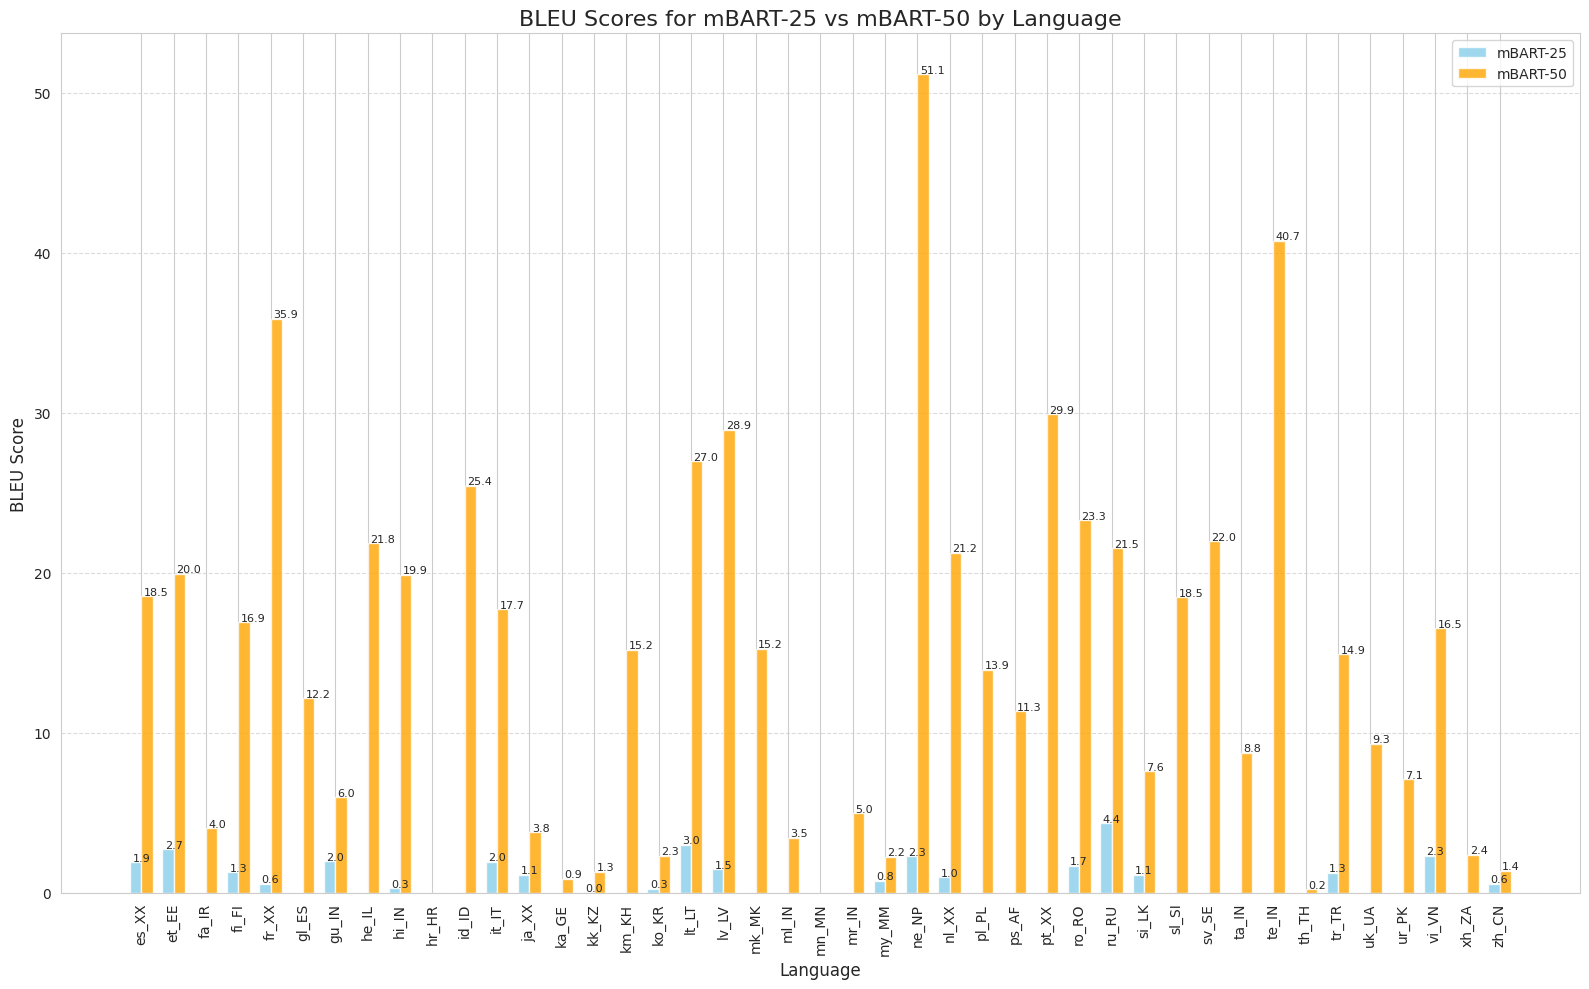

In [21]:
## Do some plot on accuracy for both models for first 100 entries on the OPUS test set
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the data
df = pd.read_csv('mbart_comparison_results2.csv')

# Replace 'Not supported' with None so we can convert to float later
df['mBART-25 BLEU'] = df['mBART-25 BLEU'].replace('Not supported', None)
df['mBART-50 BLEU'] = df['mBART-50 BLEU'].replace('Not supported', None)

# Convert to float for plotting
df['mBART-25 BLEU'] = pd.to_numeric(df['mBART-25 BLEU'], errors='coerce')
df['mBART-50 BLEU'] = pd.to_numeric(df['mBART-50 BLEU'], errors='coerce')

# Replace NaN values with 0 for plotting
df['mBART-25 BLEU'] = df['mBART-25 BLEU'].fillna(0)
df['mBART-50 BLEU'] = df['mBART-50 BLEU'].fillna(0)

# Sort by language code
df = df.sort_values('Language Code')

# Set up the plot
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# Set width of bars
bar_width = 0.35
index = np.arange(len(df))

# Create bars
plt.bar(index, df['mBART-25 BLEU'], bar_width, 
        label='mBART-25', color='skyblue', alpha=0.8)
plt.bar(index + bar_width, df['mBART-50 BLEU'], bar_width, 
        label='mBART-50', color='orange', alpha=0.8)

# Add labels, title and legend
plt.xlabel('Language', fontsize=12)
plt.ylabel('BLEU Score', fontsize=12)
plt.title('BLEU Scores for mBART-25 vs mBART-50 by Language', fontsize=16)
plt.xticks(index + bar_width / 2, df['Language Code'], rotation=90, fontsize=10)
plt.legend()

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Add values on top of bars
for i, v in enumerate(df['mBART-25 BLEU']):
    if v > 0:  # Only show value if not zero
        plt.text(i - 0.1, v + 0.1, f'{v:.1f}', fontsize=8)
        
for i, v in enumerate(df['mBART-50 BLEU']):
    if v > 0:  # Only show value if not zero
        plt.text(i + bar_width - 0.1, v + 0.1, f'{v:.1f}', fontsize=8)

# Save the figure
plt.savefig('mbart_bleu_comparison.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

#### Okay we can see there are many language pair that have low (<10) BLEU score such as en-my, en-fa, en-ko, en_zh and some of these are not present in mBART25. Let's start with Farsi (Parsian).The plan is to finetune mBART50 for Farsi and add en-fa to mBART25

In [9]:
### Finetune mBART50 for Parsian
# Load OPUS-100 English-Parsian dataset
dataset = load_dataset("opus100", "en-fa")
dataset

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [10]:
dataset["test"][:5]

{'translation': [{'en': "I'm obsolete!", 'fa': 'من دیگه به دردی نمیخورم'},
  {'en': "You've really gotta help me now.",
   'fa': 'تو واقعا ديگه بايد کمکم کني.'},
  {'en': 'The entire time you were in rehab,',
   'fa': '\u200fکل مدت\u200cزمانی که توی بازپروری بودی'},
  {'en': 'How well do you know this Dante ?',
   'fa': 'چقدر اين دانته رو ميشناسي؟'},
  {'en': 'I left my other clothes inside.', 'fa': 'لباس قبلي هامو جا گذاشتم'}]}

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [39]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
# Load model and tokenizer
model_name = "facebook/mbart-large-50-many-to-many-mmt"
model = MBartForConditionalGeneration.from_pretrained(model_name)
tokenizer = MBart50TokenizerFast.from_pretrained(model_name)

# Set source and target languages
src_lang = "en_XX"
tgt_lang = "fa_IR"
tokenizer.src_lang = src_lang


In [23]:
from torch.utils.data import DataLoader, Dataset
# Create a custom dataset
class TranslationDataset(Dataset):
    def __init__(self, dataset, tokenizer, src_lang, tgt_lang, max_length=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.max_length = max_length
        
    def __len__(self):
        return len(self.dataset)
    

    def __getitem__(self, idx):
        src_text = self.dataset[idx]["translation"]["en"]
        tgt_text = self.dataset[idx]["translation"]["fa"]
    
        self.tokenizer.src_lang = self.src_lang
        src_encoded = self.tokenizer(
            src_text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
    
        self.tokenizer.src_lang = self.tgt_lang  # Change to target lang
        tgt_encoded = self.tokenizer(
            tgt_text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
    
        input_ids = src_encoded["input_ids"].squeeze()
        attention_mask = src_encoded["attention_mask"].squeeze()
        labels = tgt_encoded["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100
    
        self.tokenizer.src_lang = self.src_lang  # Reset
    
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

# Load dataset
opus_dataset = load_dataset("opus100", "en-fa")

# Create datasets
train_dataset = TranslationDataset(opus_dataset["train"], tokenizer, src_lang, tgt_lang)
val_dataset = TranslationDataset(opus_dataset["validation"], tokenizer, src_lang, tgt_lang)


In [53]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Set up optimizer and learning rate scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_loader) * 3  # 3 epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=3e-5, 
    total_steps=total_steps
)

In [ ]:
# Training loop
num_epochs = 5
best_val_loss = float('inf')
t_loss=[]
v_loss=[]
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        train_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Average Training Loss: {avg_train_loss:.4f}")
    t_loss.append(avg_train_loss)
    # Validation
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Average Validation Loss: {avg_val_loss:.4f}")
    v_loss.append(avg_val_loss)
    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained("./mbart-en-fa-finetuned")
        tokenizer.save_pretrained("./mbart-en-fa-finetuned")
        print(f"Model saved at Epoch {epoch+1}")

print("Training complete!")

Training Epoch 1: 100%|██████████| 31250/31250 [3:12:10<00:00,  2.71it/s]  


Epoch 1: Average Training Loss: 2.1705


Validation Epoch 1: 100%|██████████| 63/63 [00:08<00:00,  7.07it/s]
/projects/gt47/amondal2/Source/miniconda3/envs/torch_2/lib/python3.10/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Epoch 1: Average Validation Loss: 1.9693
Model saved at Epoch 1


Training Epoch 2: 100%|██████████| 31250/31250 [3:12:28<00:00,  2.71it/s]   


Epoch 2: Average Training Loss: 1.7108


Validation Epoch 2: 100%|██████████| 63/63 [00:08<00:00,  7.33it/s]


Epoch 2: Average Validation Loss: 1.8015
Model saved at Epoch 2


Training Epoch 3:  26%|██▌       | 8012/31250 [49:19<2:22:34,  2.72it/s]

#### Model training failed due to filesystem isssue. I plan to extend the trainig from the checkpoint but before that I want to check the perfomence on the test set. 

In [14]:
import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from datasets import load_dataset
from sacrebleu.metrics import BLEU
from tqdm import tqdm

# Function to calculate BLEU score
def calculate_bleu(references, predictions):
    bleu = BLEU()
    return bleu.corpus_score(predictions, [references]).score

# Function to translate text using mBART model
def translate(model, tokenizer, src_texts, src_lang, tgt_lang, device="cuda" if torch.cuda.is_available() else "cpu"):
    # Prepare the text data
    model = model.to(device)
    tokenizer.src_lang = src_lang
    
    # Process in smaller batches to avoid memory issues
    batch_size = 8
    translations = []
    
    for i in range(0, len(src_texts), batch_size):
        batch_texts = src_texts[i:i+batch_size]
        
        # Tokenize the source text
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        
        # Generate translation
        with torch.no_grad():
            translated_tokens = model.generate(
                **inputs,
                forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
                max_length=128
            )
        
        # Decode the generated tokens
        batch_translations = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
        translations.extend(batch_translations)
    
    return translations



# Function to evaluate model on a given language pair
def evaluate_language_pair(model, tokenizer, src_lang, tgt_lang, test_dataset):
    # Extract source and target sentences
    src_texts = [item["translation"]["en"] for item in test_dataset]
    tgt_texts = [item["translation"]["fa"] for item in test_dataset]
    
    # Translate source texts
    translations = translate(model, tokenizer, src_texts, src_lang, tgt_lang)
    
    # Calculate BLEU score
    bleu_score = calculate_bleu(tgt_texts, translations)
    
    # Print a few examples for qualitative evaluation
    print("\nSample translations:")
    for i in range(min(3, len(translations))):
        print(f"Source: {src_texts[i]}")
        print(f"Reference: {tgt_texts[i]}")
        print(f"Translation: {translations[i]}")
        print()
    
    return bleu_score

# Load your fine-tuned model and tokenizer
print("Loading fine-tuned model...")
finetuned_model = MBartForConditionalGeneration.from_pretrained("./mbart-en-fa-finetuned")
finetuned_tokenizer = MBart50TokenizerFast.from_pretrained("./mbart-en-fa-finetuned")
print("Model loaded!")

# Set source and target languages
src_lang = "en_XX"
tgt_lang = "fa_IR"

# Load the original pre-trained model for comparison
print("Loading original pre-trained model for comparison...")
original_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
original_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
print("Original model loaded!")

# Load test dataset
print("Loading test dataset...")
test_dataset = load_dataset("opus100", "en-fa", split="test[:100]")  # Using 100 examples for quick testing
print(f"Test dataset loaded with {len(test_dataset)} examples")

# Evaluate both models
print("\nEvaluating original pre-trained model...")
original_bleu = evaluate_language_pair(original_model, original_tokenizer, src_lang, tgt_lang, test_dataset)
print(f"Original mBART-50 BLEU score: {original_bleu:.2f}")

print("\nEvaluating fine-tuned model...")
finetuned_bleu = evaluate_language_pair(finetuned_model, finetuned_tokenizer, src_lang, tgt_lang, test_dataset)
print(f"Fine-tuned model BLEU score: {finetuned_bleu:.2f}")

print(f"\nImprovement: {finetuned_bleu - original_bleu:.2f} BLEU points")

Loading fine-tuned model...
Model loaded!
Loading original pre-trained model for comparison...
Original model loaded!
Loading test dataset...
Test dataset loaded with 100 examples

Evaluating original pre-trained model...

Sample translations:
Source: I'm obsolete!
Reference: من دیگه به دردی نمیخورم
Translation: من منسوخ شده ام!

Source: You've really gotta help me now.
Reference: تو واقعا ديگه بايد کمکم کني.
Translation: شما واقعا باید به من کمک کنید.

Source: The entire time you were in rehab,
Reference: ‏کل مدت‌زمانی که توی بازپروری بودی
Translation: تمام زمانی که تو در بازپروری بودی ،

Original mBART-50 BLEU score: 4.99

Evaluating fine-tuned model...

Sample translations:
Source: I'm obsolete!
Reference: من دیگه به دردی نمیخورم
Translation: من از کار افتاده ام

Source: You've really gotta help me now.
Reference: تو واقعا ديگه بايد کمکم کني.
Translation: حالا واقعاً بايد بهم کمک کني.

Source: The entire time you were in rehab,
Reference: ‏کل مدت‌زمانی که توی بازپروری بودی
Translati

#### Awesome this is great. We imporved by 5.99 BLUE (using first 100 datapoint from test set). Let's test on the whole test set.

In [26]:
# Load your fine-tuned model and tokenizer
print("Loading fine-tuned model...")
finetuned_model = MBartForConditionalGeneration.from_pretrained("./mbart-en-fa-finetuned")
finetuned_tokenizer = MBart50TokenizerFast.from_pretrained("./mbart-en-fa-finetuned")
print("Model loaded!")

# Set source and target languages
src_lang = "en_XX"
tgt_lang = "fa_IR"

# Load the original pre-trained model for comparison
print("Loading original pre-trained model for comparison...")
original_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
original_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
print("Original model loaded!")

# Load test dataset
print("Loading test dataset...")
test_dataset = load_dataset("opus100", "en-fa", split="test")  # Using 100 examples for quick testing
print(f"Test dataset loaded with {len(test_dataset)} examples")

# Evaluate both models
print("\nEvaluating original pre-trained model...")
original_bleu = evaluate_language_pair(original_model, original_tokenizer, src_lang, tgt_lang, test_dataset)
print(f"Original mBART-50 BLEU score: {original_bleu:.2f}")

print("\nEvaluating fine-tuned model...")
finetuned_bleu = evaluate_language_pair(finetuned_model, finetuned_tokenizer, src_lang, tgt_lang, test_dataset)
print(f"Fine-tuned model BLEU score: {finetuned_bleu:.2f}")

print(f"\nImprovement: {finetuned_bleu - original_bleu:.2f} BLEU points")

Loading fine-tuned model...
Model loaded!
Loading original pre-trained model for comparison...
Original model loaded!
Loading test dataset...
Test dataset loaded with 2000 examples

Evaluating original pre-trained model...

Sample translations:
Source: I'm obsolete!
Reference: من دیگه به دردی نمیخورم
Translation: من منسوخ شده ام!

Source: You've really gotta help me now.
Reference: تو واقعا ديگه بايد کمکم کني.
Translation: شما واقعا باید به من کمک کنید.

Source: The entire time you were in rehab,
Reference: ‏کل مدت‌زمانی که توی بازپروری بودی
Translation: تمام زمانی که تو در بازپروری بودی ،

Original mBART-50 BLEU score: 4.53

Evaluating fine-tuned model...


That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Sample translations:
Source: I'm obsolete!
Reference: من دیگه به دردی نمیخورم
Translation: من از کار افتاده ام

Source: You've really gotta help me now.
Reference: تو واقعا ديگه بايد کمکم کني.
Translation: حالا واقعاً بايد بهم کمک کني.

Source: The entire time you were in rehab,
Reference: ‏کل مدت‌زمانی که توی بازپروری بودی
Translation: تمام مدتي که تو اعتياد بودي

Fine-tuned model BLEU score: 10.46

Improvement: 5.93 BLEU points


#### This is awesome, the finetuned model improve the BLEU score on the whole test set by ~6 BLEU

#### Retrain few more epochs to get even better translation

In [29]:
# Load the saved model and tokenizer
model = MBartForConditionalGeneration.from_pretrained("./mbart-en-fa-finetuned")
tokenizer = MBart50TokenizerFast.from_pretrained("./mbart-en-fa-finetuned")

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set source and target languages
src_lang = "en_XX"
tgt_lang = "fa_IR"
tokenizer.src_lang = src_lang

# Recreate dataloaders with smaller batch size
batch_size = 32
train_dataset = TranslationDataset(opus_dataset["train"], tokenizer, src_lang, tgt_lang)
val_dataset = TranslationDataset(opus_dataset["validation"], tokenizer, src_lang, tgt_lang)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Reset optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)  # Slightly lower learning rate
total_steps = len(train_loader) * 2  # Remaining epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=2e-5, 
    total_steps=total_steps
)

# Continue training from epoch 3
num_epochs = 2  # Number of additional epochs
best_val_loss = 1.8015  # Your last reported validation loss

In [30]:
t_loss = [2.1705, 1.7108]  # previous training losses, tracked it from the trainig print
v_loss = [1.9693, 1.8015]  # previous validation losses

for epoch in range(3, 3 + num_epochs):  # Start from epoch 3
    # Training
    model.train()
    train_loss = 0
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        train_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss:.4f}")
    t_loss.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss:.4f}")
    v_loss.append(avg_val_loss)
    
    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained("./mbart-en-fa-finetuned-continued")
        tokenizer.save_pretrained("./mbart-en-fa-finetuned-continued")
        print(f"Model saved at Epoch {epoch}")

print("Training complete!")

Training Epoch 3: 100%|██████████| 31250/31250 [3:11:26<00:00,  2.72it/s]  


Epoch 3: Average Training Loss: 1.4714


Validation Epoch 3: 100%|██████████| 63/63 [00:08<00:00,  7.07it/s]


Epoch 3: Average Validation Loss: 1.8030


Training Epoch 4: 100%|██████████| 31250/31250 [3:11:28<00:00,  2.72it/s]  


Epoch 4: Average Training Loss: 1.3373


Validation Epoch 4: 100%|██████████| 63/63 [00:08<00:00,  7.34it/s]


Epoch 4: Average Validation Loss: 1.7814
Model saved at Epoch 4
Training complete!


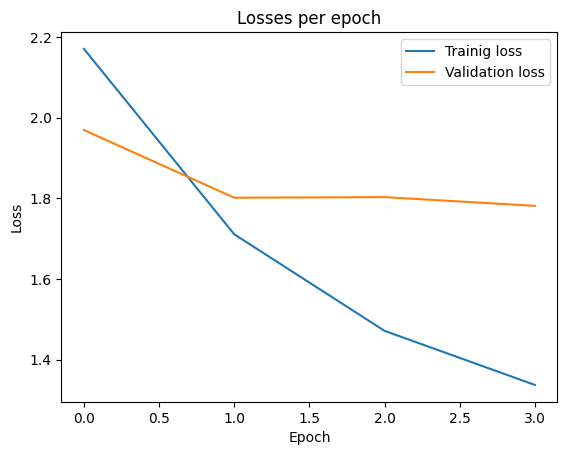

In [2]:
#plot losses
from matplotlib import pyplot as plt
plt.plot(t_loss, label='Trainig loss')
plt.plot(v_loss, label='Validation loss')
plt.title('Losses per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Finetuning_losses_mbart50.pdf')
plt.show()


#### Seems model is overfitting with more training as training loss is decresing significantly but not much effect on validation loss. Use the best saved finetuned model and estimate the BLEU score for the entire test set


In [36]:
# Load your fine-tuned model and tokenizer
print("Loading fine-tuned model...")
finetuned_model = MBartForConditionalGeneration.from_pretrained("./mbart-en-fa-finetuned-continued")
finetuned_tokenizer = MBart50TokenizerFast.from_pretrained("./mbart-en-fa-finetuned-continued")
print("Model loaded!")

# Set source and target languages
src_lang = "en_XX"
tgt_lang = "fa_IR"

# Load test dataset
print("Loading test dataset...")
test_dataset = load_dataset("opus100", "en-fa", split="test")  # Using 100 examples for quick testing
print(f"Test dataset loaded with {len(test_dataset)} examples")

print("\nEvaluating fine-tuned model...")
finetuned_bleu = evaluate_language_pair(finetuned_model, finetuned_tokenizer, src_lang, tgt_lang, test_dataset)
print(f"Fine-tuned model BLEU score: {finetuned_bleu:.2f}")

print(f"\nImprovement: {finetuned_bleu - original_bleu:.2f} BLEU points")

Loading fine-tuned model...
Model loaded!
Loading test dataset...
Test dataset loaded with 2000 examples

Evaluating fine-tuned model...


That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Sample translations:
Source: I'm obsolete!
Reference: من دیگه به دردی نمیخورم
Translation: من کهنه ام!

Source: You've really gotta help me now.
Reference: تو واقعا ديگه بايد کمکم کني.
Translation: حالا ديگه واقعاً بايد کمکم کني.

Source: The entire time you were in rehab,
Reference: ‏کل مدت‌زمانی که توی بازپروری بودی
Translation: تمام مدتي که داشتي ترک ميکردي

Fine-tuned model BLEU score: 10.94

Improvement: 6.41 BLEU points


#### Okay after 2 more epochs, the BLEU score improved by 6.41 BLEU. Final BLEU is ~11. This is a significant improvement

#### Check the METEOR score as more advance accuracy metric. 

In [38]:
!pip install nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.8 MB/s eta 0:00:00


In [40]:
from nltk.translate.meteor_score import meteor_score
import nltk


# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')



# Function to calculate METEOR score
def calculate_meteor(references, predictions):
    meteor_scores = []
    for ref, pred in zip(references, predictions):
        # Convert to list of tokens for METEOR
        ref_tokens = ref.split()
        pred_tokens = pred.split()
        score = meteor_score([ref_tokens], pred_tokens)
        meteor_scores.append(score)
    return sum(meteor_scores) / len(meteor_scores)


# Function to evaluate model on a given language pair
def evaluate_model(model, tokenizer, src_lang, tgt_lang, test_dataset):
    # Extract source and target sentences
    src_texts = [item["translation"]["en"] for item in test_dataset]
    tgt_texts = [item["translation"]["fa"] for item in test_dataset]  # Adjust language code as needed
    
    # Translate source texts
    translations = translate(model, tokenizer, src_texts, src_lang, tgt_lang)
    
    meteor_score = calculate_meteor(tgt_texts, translations)
    
    # Print a few examples for qualitative evaluation
    print("\nSample translations:")
    for i in range(min(3, len(translations))):
        print(f"Source: {src_texts[i]}")
        print(f"Reference: {tgt_texts[i]}")
        print(f"Translation: {translations[i]}")
        print()
    
    return {
        "METEOR": meteor_score
    }

# Main evaluation function
def compare_models():
    # Load models and tokenizers
    print("Loading original pre-trained model...")
    original_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
    original_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
    
    print("Loading fine-tuned model...")
    finetuned_model = MBartForConditionalGeneration.from_pretrained("./mbart-en-fa-finetuned-continued")
    finetuned_tokenizer = MBart50TokenizerFast.from_pretrained("./mbart-en-fa-finetuned-continued")
    
    # Load test dataset
    print("Loading test dataset...")
    test_dataset = load_dataset("opus100", "en-fa", split="test")
    
    # Source and target languages
    src_lang = "en_XX"
    tgt_lang = "fa_IR"
    
    # Evaluate original model
    print("\nEvaluating original pre-trained model...")
    original_scores = evaluate_model(original_model, original_tokenizer, src_lang, tgt_lang, test_dataset)
    
    # Evaluate fine-tuned model
    print("\nEvaluating fine-tuned model...")
    finetuned_scores = evaluate_model(finetuned_model, finetuned_tokenizer, src_lang, tgt_lang, test_dataset)
    
    # Print comparison
    print("\n===== Model Comparison =====")
    
    print(f"\nOriginal mBART-50 METEOR: {original_scores['METEOR']:.4f}")
    print(f"Fine-tuned METEOR: {finetuned_scores['METEOR']:.4f}")
    print(f"METEOR Improvement: {finetuned_scores['METEOR'] - original_scores['METEOR']:.4f} points")
    
    return {
        "original": original_scores,
        "finetuned": finetuned_scores
    }

# Run evaluation
if __name__ == "__main__":
    results = compare_models()

[nltk_data] Downloading package wordnet to /home/amondal2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/amondal2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loading original pre-trained model...
Loading fine-tuned model...
Loading test dataset...

Evaluating original pre-trained model...

Sample translations:
Source: I'm obsolete!
Reference: من دیگه به دردی نمیخورم
Translation: من منسوخ شده ام!

Source: You've really gotta help me now.
Reference: تو واقعا ديگه بايد کمکم کني.
Translation: شما واقعا باید به من کمک کنید.

Source: The entire time you were in rehab,
Reference: ‏کل مدت‌زمانی که توی بازپروری بودی
Translation: تمام زمانی که تو در بازپروری بودی ،


Evaluating fine-tuned model...

Sample translations:
Source: I'm obsolete!
Reference: من دیگه به دردی نمیخورم
Translation: من کهنه ام!

Source: You've really gotta help me now.
Reference: تو واقعا ديگه بايد کمکم کني.
Translation: حالا ديگه واقعاً بايد کمکم کني.

Source: The entire time you were in rehab,
Reference: ‏کل مدت‌زمانی که توی بازپروری بودی
Translation: تمام مدتي که داشتي ترک ميکردي


===== Model Comparison =====

Original mBART-50 METEOR: 0.1361
Fine-tuned METEOR: 0.2526
METEOR

#### We completed our finetuning for mBART50 on English-Farsi language and both BLEU and METEOR score improved by ~6.5 and 0.1165 respectively which is incredible. 

#### Finetune mBART35: 
#### mBART25 does not have Farsi. We can finetune it 2 ways- 
#### 1. A simpler approach: Use similar language AR to understand Fa tokens and then finetune in a similar way as mBART50
#### 2. A more complex approach: Adding the Parsian token, extend the embedding matrix etc.
#### Here just for a parallel test of two mBART models, I am following the first simpler approach.

In [44]:
import torch
from transformers import MBartForConditionalGeneration, MBartTokenizer
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
#import evaluate
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load mBART-25 model and tokenizer
model_name = "facebook/mbart-large-cc25"
model = MBartForConditionalGeneration.from_pretrained(model_name)
tokenizer = MBartTokenizer.from_pretrained(model_name)

# Print available language tokens
print(f"Available language tokens: {list(tokenizer.lang_code_to_id.keys())}")

# Choose a substitute language token for Persian (fa_IR)
# Arabic (ar_AR) is a reasonable choice as it shares some similarities
src_lang = "en_XX"
tgt_lang = "ar_AR"  # Using Arabic token as a substitute for Persian
tokenizer.src_lang = src_lang

# Load OPUS-100 English-Persian dataset
opus_dataset = load_dataset("opus100", "en-fa")
print(f"Train set size: {len(opus_dataset['train'])}")
print(f"Validation set size: {len(opus_dataset['validation'])}")
print(f"Test set size: {len(opus_dataset['test'])}")

# Create a custom dataset
class TranslationDataset(Dataset):
    def __init__(self, dataset, tokenizer, src_lang, tgt_lang, max_length=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.max_length = max_length
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Get source and target texts
        src_text = self.dataset[idx]["translation"]["en"]
        tgt_text = self.dataset[idx]["translation"]["fa"]
        
        # Tokenize source text
        self.tokenizer.src_lang = self.src_lang
        src_encoded = self.tokenizer(
            src_text, 
            max_length=self.max_length, 
            truncation=True, 
            padding="max_length", 
            return_tensors="pt"
        )
        
        # Tokenize target text - use Arabic token but Persian text
        self.tokenizer.src_lang = self.tgt_lang  # Using Arabic token
        tgt_encoded = self.tokenizer(
            tgt_text,  # Persian text
            max_length=self.max_length, 
            truncation=True, 
            padding="max_length", 
            return_tensors="pt"
        )
        
        input_ids = src_encoded["input_ids"].squeeze()
        attention_mask = src_encoded["attention_mask"].squeeze()
        labels = tgt_encoded["input_ids"].squeeze()
        
        # Replace padding token id with -100 for loss calculation
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        # Reset tokenizer language
        self.tokenizer.src_lang = self.src_lang
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

# Create train and validation datasets
train_dataset = TranslationDataset(opus_dataset["train"], tokenizer, src_lang, tgt_lang)
val_dataset = TranslationDataset(opus_dataset["validation"], tokenizer, src_lang, tgt_lang)

# Set batch size based on available memory
batch_size = 32 # same as earlier 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Move model to device
model.to(device)

# Set up optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_loader) * 2  # 2 epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=3e-5, 
    total_steps=total_steps
)

# Training loop
num_epochs = 2
best_val_loss = float('inf')
t_loss = []
v_loss = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        train_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Average Training Loss: {avg_train_loss:.4f}")
    t_loss.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Average Validation Loss: {avg_val_loss:.4f}")
    v_loss.append(avg_val_loss)
    
    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained("./mbart25-en-fa-finetuned")
        tokenizer.save_pretrained("./mbart25-en-fa-finetuned")
        print(f"Model saved at Epoch {epoch+1}")

print("Training complete!")


Using device: cuda
Available language tokens: ['ar_AR', 'cs_CZ', 'de_DE', 'en_XX', 'es_XX', 'et_EE', 'fi_FI', 'fr_XX', 'gu_IN', 'hi_IN', 'it_IT', 'ja_XX', 'kk_KZ', 'ko_KR', 'lt_LT', 'lv_LV', 'my_MM', 'ne_NP', 'nl_XX', 'ro_RO', 'ru_RU', 'si_LK', 'tr_TR', 'vi_VN', 'zh_CN']
Train set size: 1000000
Validation set size: 2000
Test set size: 2000


Training Epoch 1: 100%|██████████| 31250/31250 [3:12:22<00:00,  2.71it/s]  


Epoch 1: Average Training Loss: 3.5010


Validation Epoch 1: 100%|██████████| 63/63 [00:08<00:00,  7.13it/s]
/projects/gt47/amondal2/Source/miniconda3/envs/torch_2/lib/python3.10/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1024, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Epoch 1: Average Validation Loss: 2.1968
Model saved at Epoch 1


IOPub message rate exceeded.▏    | 16275/31250 [1:40:04<1:31:55,  2.72it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training Epoch 2: 100%|██████████| 31250/31250 [3:12:15<00:00,  2.71it/s]


Epoch 2: Average Training Loss: 1.9150


Validation Epoch 2: 100%|██████████| 63/63 [00:08<00:00,  7.41it/s]


Epoch 2: Average Validation Loss: 1.9627
Model saved at Epoch 2
Training complete!


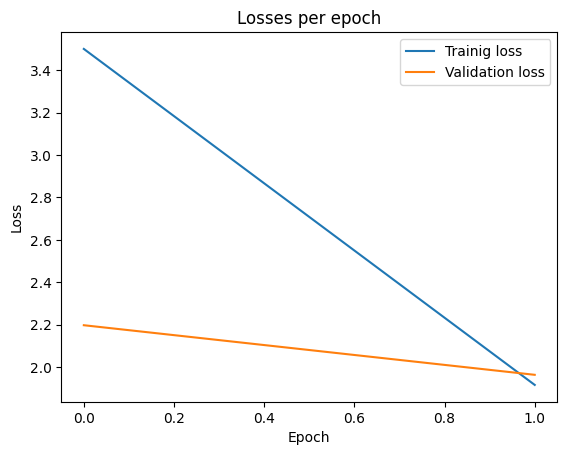

In [4]:
#plot losses

plt.plot(t_loss, label='Trainig loss')
plt.plot(v_loss, label='Validation loss')
plt.title('Losses per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Finetuning_losses_mbart25.pdf')
plt.show()

In [46]:
# Add a test function to verify translation
def test_model(model, tokenizer, test_dataset, num_examples=5):
    model.eval()
    
    for i in range(num_examples):
        # Get a test example
        example = test_dataset[i]
        src_text = example["translation"]["en"]
        ref_text = example["translation"]["fa"]
        
        # Tokenize input
        tokenizer.src_lang = src_lang
        inputs = tokenizer(src_text, return_tensors="pt", padding=True).to(device)
        
        # Generate translation
        with torch.no_grad():
            translated_tokens = model.generate(
                **inputs,
                forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
                max_length=128
            )
        
        # Decode translation
        translation = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)[0]
        
        # Print results
        print(f"\nExample {i+1}:")
        print(f"Source (English): {src_text}")
        print(f"Reference (Persian): {ref_text}")
        print(f"Model Translation: {translation}")

# Test the model with a few examples
test_model(model, tokenizer, opus_dataset["test"])


Example 1:
Source (English): I'm obsolete!
Reference (Persian): من دیگه به دردی نمیخورم
Model Translation: من منسوخ شدم!

Example 2:
Source (English): You've really gotta help me now.
Reference (Persian): تو واقعا ديگه بايد کمکم کني.
Model Translation: تو واقعا بايد بهم کمک کني

Example 3:
Source (English): The entire time you were in rehab,
Reference (Persian): ‏کل مدت‌زمانی که توی بازپروری بودی
Model Translation: تمام مدتي که تو توي بازنشستگي بودي

Example 4:
Source (English): How well do you know this Dante ?
Reference (Persian): چقدر اين دانته رو ميشناسي؟
Model Translation: اين "دنته" رو چقدر خوب ميشناسي؟

Example 5:
Source (English): I left my other clothes inside.
Reference (Persian): لباس قبلي هامو جا گذاشتم
Model Translation: لباساي ديگه ام رو توش گذاشتم


In [49]:
def calculate_bleu(model, tokenizer, test_dataset, src_lang="en_XX", tgt_lang="ar_AR"):
    model.eval()
    references = []
    translations = []
    
    # Process in batches to avoid memory issues
    batch_size = 8
    device = next(model.parameters()).device  # Get the device from model
    
    # Process the whole dataset batch by batch
    for i in range(0, len(test_dataset), batch_size):
        # Get a batch of examples
        batch_indices = list(range(i, min(i+batch_size, len(test_dataset))))
        
        # Get source and reference texts
        src_texts = [test_dataset[idx]["translation"]["en"] for idx in batch_indices]
        ref_texts = [test_dataset[idx]["translation"]["fa"] for idx in batch_indices]
        references.extend(ref_texts)
        
        # Tokenize inputs
        tokenizer.src_lang = src_lang
        inputs = tokenizer(src_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        
        # Generate translations
        with torch.no_grad():
            translated_tokens = model.generate(
                **inputs,
                forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
                max_length=128,
                num_beams=5
            )
        
        # Decode translations
        batch_translations = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
        translations.extend(batch_translations)
    
    # Calculate BLEU score
    bleu = BLEU()
    score = bleu.corpus_score(translations, [references])
    
    return score.score

# Add this at the end of your script after training
print("\nEvaluating BLEU score on test set...")
test_dataset = opus_dataset["test"].select(range(100))  # Use 100 examples for quicker testing
mbart25_bleu = calculate_bleu(model, tokenizer, test_dataset)
print(f"mBART-25 fine-tuned BLEU score: {mbart25_bleu:.2f}")


Evaluating BLEU score on test set...
mBART-25 fine-tuned BLEU score: 6.63


In [50]:
def calculate_meteor(model, tokenizer, test_dataset, src_lang="en_XX", tgt_lang="ar_AR"):
    import nltk
    from nltk.translate.meteor_score import meteor_score
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    
    model.eval()
    meteor_scores = []
    translations = []
    
    # Process in batches
    batch_size = 8
    device = next(model.parameters()).device
    
    # Process the dataset batch by batch
    for i in range(0, len(test_dataset), batch_size):
        # Get a batch of examples
        batch_indices = list(range(i, min(i+batch_size, len(test_dataset))))
        
        # Get source and reference texts
        src_texts = [test_dataset[idx]["translation"]["en"] for idx in batch_indices]
        ref_texts = [test_dataset[idx]["translation"]["fa"] for idx in batch_indices]
        
        # Tokenize inputs
        tokenizer.src_lang = src_lang
        inputs = tokenizer(src_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        
        # Generate translations
        with torch.no_grad():
            translated_tokens = model.generate(
                **inputs,
                forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
                max_length=128,
                num_beams=5
            )
        
        # Decode translations
        batch_translations = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
        translations.extend(batch_translations)
        
        # Calculate METEOR for each sentence
        for ref, pred in zip(ref_texts, batch_translations):
            # Split into tokens
            ref_tokens = ref.split()
            pred_tokens = pred.split()
            # Calculate METEOR
            score = meteor_score([ref_tokens], pred_tokens)
            meteor_scores.append(score)
    
    # Calculate average METEOR score
    avg_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    
    return avg_meteor

# Add this after your BLEU calculation
print("\nEvaluating METEOR score on test set...")
mbart25_meteor = calculate_meteor(model, tokenizer, test_dataset)
print(f"mBART-25 fine-tuned METEOR score: {mbart25_meteor:.4f}")
    


Evaluating METEOR score on test set...
mBART-25 fine-tuned METEOR score: 0.2248


#### As we can see here, after a couple of epoch, the model can predict translation from English to Parsian but the accuracy is low as expected. Here BLEU is 6.63 which is higher than the BLEU score of pretrained mBART-50 model, which is some improvement. Also, METEOR score of pretrained mBART-50 was 0.1361, whereas finetuned mBART-25 has 0.2248. So this also an significant improvement. However, as we were not able to match the accuracy level of mBART-50 finetuned as expected as mBART-50 was already trained with English-Farsi translattion whereas for mBART-25, it was a completely new language. Let's plot all the evaluation of mBART-25, mBART-50 pretrained and finetuned models.

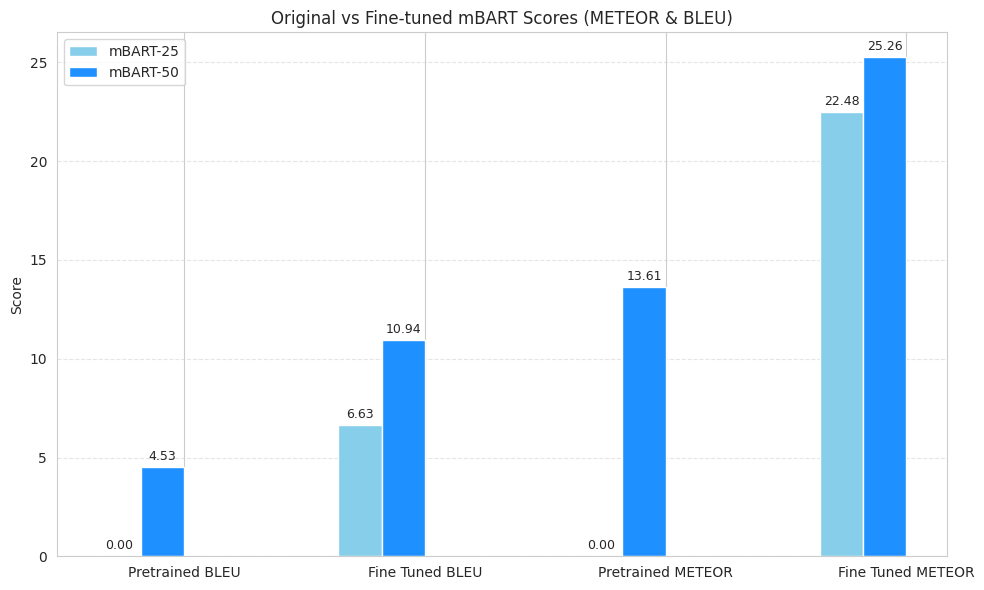

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Scores
models = ['Pretrained BLEU','Fine Tuned BLEU','Pretrained METEOR','Fine Tuned METEOR']
#meteor_original = [0.1361, 0.0]
#meteor_finetuned = [0.2526, 0.2248]
#bleu_original = [4.53, 0.0]
#bleu_finetuned = [10.94, 6.63]
mbart_25=[0,6.63,0,22.48]
mbart_50=[4.53,10.94,13.61,25.26]

x = np.arange(len(models))  # mBART-50, mBART-25
width = 0.18

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
b1 = ax.bar(x - 1.5*width, mbart_25, width, label='mBART-25', color='skyblue')
b2 = ax.bar(x - 0.5*width, mbart_50, width, label='mBART-50', color='dodgerblue')
#b3 = ax.bar(x + 0.5*width, bleu_original, width, label='Original BLEU', color='lightcoral')
#b4 = ax.bar(x + 1.5*width, bleu_finetuned, width, label='Fine-tuned BLEU', color='firebrick')

# Axis labels and ticks
ax.set_ylabel('Score')
ax.set_title('Original vs Fine-tuned mBART Scores (METEOR & BLEU)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate bars with values
def annotate(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

for bar_group in [b1, b2]:
    annotate(bar_group)

plt.tight_layout()
plt.savefig('Final_evaluation.pdf')
plt.show()


#### We can clearly see from this plot, the improvement upon finetuning for both mBART-50 and mBART-25. "0" represents that this language was out of scope for mBART-25 pretrained. To recap: we finetune mBART-25 for a language that it was not trained for originally and we finetuned mBART-50 for a language that it was already trained for but perfomance was poor.